In [23]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Create output folder
import os
#output_folder = "recommendations"
output_folder = "data/daily"

os.makedirs(output_folder, exist_ok=True)

In [24]:
# URLs
URL_GAINERS = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=day_gainers&count=250"
URL_ACTIVE = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=most_actives&count=250"
URL_TRENDING = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=trending_tickers&count=250"

In [25]:
def fetch_screener(scrId, count=250): 
    url = f"https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds={scrId}&count={count}"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading screener {scrId}: {e}")


In [26]:
def fetch_trending():
    url = "https://query1.finance.yahoo.com/v1/finance/trending/US"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading trending {e}")

In [27]:
import re

def filter_equities(df):
    eq = []
    for s in df["symbol"]:
        if re.fullmatch(r"[A-Za-z][A-Za-z0-9\.-]{0,9}", s):
            eq.append(s)
    return pd.DataFrame({"symbol": eq})


In [28]:
print("Downloading Yahoo lists...")

df_gainers = fetch_screener("day_gainers")
df_active  = fetch_screener("most_actives")
df_trending_raw = fetch_trending()
df_trending = filter_equities(df_trending_raw)


print("Gainers:", len(df_gainers))
print("Most Active:", len(df_active))
print("Trending:", len(df_trending))

combined = pd.concat([df_gainers, df_active, df_trending], ignore_index=True)
combined.drop_duplicates(subset="symbol", inplace=True)

print("Total unique hot symbols:", len(combined))


Gainers: 87
Most Active: 250
Trending: 20
Total unique hot symbols: 324


In [29]:
def fix_num(x):
    """
    Convert Yahoo formatted numbers:
    '1.2M', '330K', '2.3B' → float
    """
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    x = str(x).replace(",", "")

    try:
        if x.endswith("M"):
            return float(x[:-1]) * 1e6
        if x.endswith("B"):
            return float(x[:-1]) * 1e9
        if x.endswith("K"):
            return float(x[:-1]) * 1e3
        return float(x)
    except:
        return np.nan

numeric_cols = [
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketChange",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap"
]

for col in numeric_cols:
    if col in combined.columns:
        combined[col] = combined[col].apply(fix_num)

In [30]:
df = combined.copy()

# Volume Spike Score
df["VolumeSpike"] = df["regularMarketVolume"] / df["averageDailyVolume3Month"]
df["VolumeScore"] = df["VolumeSpike"].rank(pct=True)

# Momentum Score (based on daily % change)
df["MomentumScore"] = df["regularMarketChangePercent"].rank(pct=True)

# Volatility Score (higher movement = more hot)
df["VolatilityScore"] = df["regularMarketChange"].abs().rank(pct=True)

# Trend Score (proxy: price vs avg volume)
df["TrendScore"] = (df["regularMarketPrice"] / (df["averageDailyVolume3Month"] + 1)).rank(pct=True)

# Final score
df["HotScore"] = (
    0.35 * df["MomentumScore"] +
    0.35 * df["VolumeScore"] +
    0.20 * df["VolatilityScore"] +
    0.10 * df["TrendScore"]
)

df.sort_values("HotScore", ascending=False, inplace=True)

# Keep relevant columns
output_df = df[[
    "symbol",
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore",
    "HotScore"
]]

In [31]:
top50 = output_df.head(50)


timestamp = datetime.now().strftime("%Y%m%d%H%M%S") 
file_path = os.path.join(output_folder, f"hot_stocks_{timestamp}.csv")
top50.to_csv(file_path, index=False)

print("\n🔥 Saved TOP 50 hot stocks to:", file_path)
top50



🔥 Saved TOP 50 hot stocks to: data/daily\hot_stocks_20251119141705.csv


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore
14,JAZZ,180.520,6.132050,4158156.0,886101.0,1.096932e+10,4.692643,0.951768,0.990354,0.980707,0.987138,0.974598
1,DGNX,16.200,19.205300,2847189.0,810684.0,3.288687e+09,3.512082,0.996785,0.980707,0.839228,0.819936,0.941961
21,BLTE,123.190,5.371650,136035.0,67864.0,4.298222e+09,2.004524,0.929260,0.932476,0.945338,1.000000,0.940675
17,MSTR,206.800,5.823360,21788897.0,12107217.0,5.942475e+10,1.799662,0.945338,0.903537,0.983923,0.803859,0.924277
29,MDT,100.800,4.694640,21637936.0,6968298.0,1.292877e+11,3.105197,0.903537,0.977492,0.916399,0.784566,0.920096
6,AS,33.360,8.452540,13788335.0,5237193.0,1.850050e+10,2.632772,0.980707,0.961415,0.836013,0.636656,0.910611
7,TERN,27.560,7.824730,5333568.0,2454581.0,2.482599e+09,2.172904,0.977492,0.942122,0.790997,0.742765,0.904341
51,NTRA,213.650,3.693460,2116335.0,1191345.0,2.948679e+10,1.776425,0.829582,0.893891,0.958199,0.983923,0.893248
22,GLBE,37.010,5.351540,2742047.0,1386837.0,6.281562e+09,1.977195,0.926045,0.926045,0.784566,0.871383,0.892283
27,TIGO,56.100,4.801050,1601604.0,928968.0,9.373468e+09,1.724068,0.909968,0.890675,0.832797,0.935691,0.890354


In [32]:
top50['symbol']

14     JAZZ
1      DGNX
21     BLTE
17     MSTR
29      MDT
6        AS
7      TERN
51     NTRA
22     GLBE
27     TIGO
2       LGN
13     LQDA
44      MRK
4      SRRK
28     CHDN
41      VLO
23     NBIS
60     BFAM
0      ONDS
73      MOH
10      JHX
62     HTFL
20     UPWK
26     LSCC
61      TFX
49     EXAS
33     ARQT
83     PCAR
31     CWAN
70     TMDX
46     CNTA
9      QUBT
12       MH
77      ALB
39     WRBY
75     WAFD
117     LNW
211    BRBR
63     NFLX
50      CLH
47     DECK
331    BIDU
5      WULF
24     MSGE
32     BMNR
67       BL
309    DASH
25     UPST
48     TARS
3       TMC
Name: symbol, dtype: object

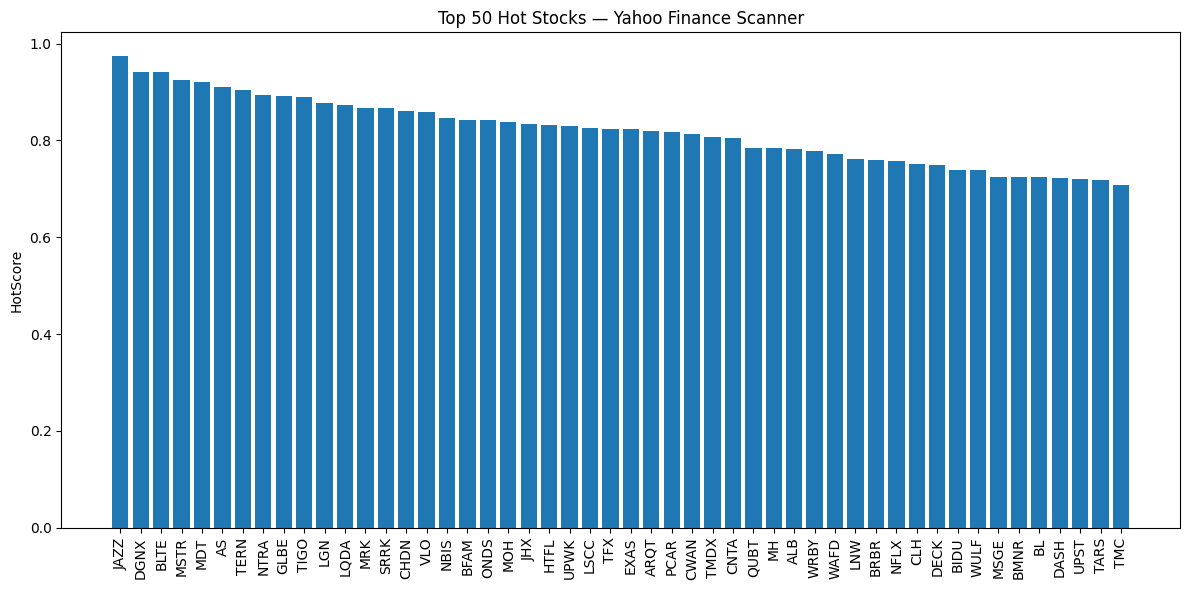

In [33]:

# --------------------------------------------------------
# 6. Plot Heat Bar
# --------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.bar(top50["symbol"], top50["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 50 Hot Stocks — Yahoo Finance Scanner")
plt.ylabel("HotScore")
plt.tight_layout()
plt.show()